University of Helsinki, Master's Programme in Mathematics and Statistics  
MAST32001 Computational Statistics, Autumn 2023  
Luigi Acerbi

# Week 3 exercises

**General hints**:  
- **In order to estimate the accuracy of your answer**, it is recommended to run the sampler a few times and compute the standard deviation of the values you obtain. If the standard deviation of the values you obtain is smaller than the tolerance, the average of the values you obtain should be within the tolerance, assuming everything was done correctly.
- Monte Carlo error scales as $1/\sqrt{n}$ with the number of iterations $n$, i.e. you need to increase the number of iterations by a factor of 4 to cut the error in half.

In [ ]:
from typing import Callable
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from functools import partial
from typing import Any
from scipy.optimize import minimize, Bounds, shgo


plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 14

sns.set_style("whitegrid")


rng = np.random.default_rng(12345)


## 1. Sampling a 1D distribution (4 points)

Write a Metropolis-Hastings sampler to sample from the (unnormalised) distribution
$$ P^*(\theta) = \cos^2(\theta) \exp(-|\theta|^3) $$
using a normal distribution with standard deviation $\sigma$ as the proposal
$q(\theta' ; \theta) = \mathcal{N}(\theta';\; \theta, \sigma^2)$.

1. Initialising the sampler at $\theta = 0$, draw 10000 samples with $\sigma=0.5$. Report the acceptance rate of the samples in Moodle.
2. Find a value of $\sigma$ that gives an acceptance rate close to the theoretically optimal value of $0.5$.
3. Evaluate $\mathbb{E}[\cos(\theta)]$, using samples drawn with the optimally tuned $\sigma$. Remember to throw out the warm-up samples! Report the value you obtain in Moodle.

The required tolerance for the answer is $\pm 0.03$.

*Hint*: It is useful to check your result by plotting a histogram of your samples and the target density (remembering it is unscaled).

In [ ]:
# 1
def metropolis_hastings(theta0: float, n: int, log_target: Callable[[float], float], log_proposal: Callable[[float], float]) -> tuple[np.ndarray, float]:
    theta = theta0
    samples = np.zeros(n)
    accepts = 0
    for i in range(n):
        theta_prop = log_proposal(theta)
        u = rng.uniform()
        if np.log(u) < log_target(theta_prop) - log_target(theta):
            theta = theta_prop
            accepts += 1
        samples[i] = theta
    return samples, accepts / n

sd = 0.5
n = 10000
log_target = lambda theta: np.log(2 * np.cos(theta)) + ( -np.abs(theta)**3)
log_proposal = lambda theta: stats.norm(theta, sd**2).rvs()

samples, acceptance_rate = metropolis_hastings(0.0, 1000, log_target, log_proposal)
print(f"Acceptance rate: {acceptance_rate}")

sns.histplot(samples, stat="density", bins=50)


In [ ]:
# 2

# let's use a halfnormal to try and find appropriate values for sigma

n_sigma = 100
sigma_candidates = stats.halfnorm(scale=1.5).rvs(n_sigma)
acceptance_rates = np.zeros(n_sigma)
best_acceptance_rate_diff = .5
best_sigma = None
for i in range(n_sigma):
    s = sigma_candidates[i]
    samples, acceptance_rate = metropolis_hastings(0.0, n, log_target, lambda theta: stats.norm(theta, s**2).rvs())
    acceptance_rates[i] = acceptance_rate
    acceptance_diff = np.abs(.5 - acceptance_rate)
    if acceptance_diff < best_acceptance_rate_diff:
        best_acceptance_rate_diff = acceptance_diff
        best_sigma = s
        print(f"New best sigma: {best_sigma}")
        print(f"Acceptance rate: {acceptance_rate}")

opt_accept = np.abs(.5 - acceptance_rates)
opt_index = np.argmin(opt_accept)
print(f"Optimal sigma: {sigma_candidates[opt_index]}")
print(f"Acceptance rate: {acceptance_rates[opt_index]}")
opt_sigma = sigma_candidates[opt_index]


In [ ]:
opt_sigma

In [ ]:
results = np.zeros(10)
for i in range(len(results)):
    samples, acceptance_rate = metropolis_hastings(0.0, n, log_target, lambda theta: stats.norm(theta, 1.05**2).rvs())
    _, valid_samples = samples[:n//2], samples[n//2:]
    y = np.mean(np.cos(valid_samples))
    results[i] = y


In [ ]:
sns.displot(np.cos(valid_samples), stat="density", bins=50)

In [ ]:
results.std()
results.mean()

## 2. Sampling a 2D distribution (4 points)

Write a Metropolis-Hastings sampler to evaluate the following expectations over the given (unnormalised) distributions using a suitably scaled multivariate normal distribution with diagonal covariance as the proposal.

1. $E[\theta_1^2 + \theta_2^2]$, when $P^*(\boldsymbol{\theta}) = \exp\left(-3(\sqrt{(\theta_1-\mu_1)^2 + (\theta_2-\mu_2)^2} - r^2)^2 \right)$.
2. $E[\theta_1^2 + \theta_2^2]$, when $P^*(\boldsymbol{\theta}) = \exp\left(-3(\sqrt{(\theta_1-\mu_1)^2 + (\theta_2-\mu_2)^2} - r^2)^2 + |2\theta_1 - \theta_2|\right)$.

Here $\mu_1 = 1, \mu_2 = 2$ and $r = \sqrt{2}$.

The required tolerance for the answer is $\pm 0.3$.

*Hint*: It is useful to check your result by plotting a scatter plot of your samples and a contour plot of the logarithm of the target function. Remember to throw out the warm-up samples!

In [ ]:
mu_1 = 1
mu_2 = 2
r = np.sqrt(2)

def vectorised_mh_mcmc(theta0: np.ndarray,
                        sigma: np.ndarray, n: int, log_target: Callable[[ np.ndarray],  np.ndarray], log_proposal: Callable[[np.ndarray, np.ndarray],  np.ndarray]) -> tuple[np.ndarray, float]:
    theta = theta0
    samples = np.zeros(shape=(n, theta0.shape[0]))
    accepts = 0
    for i in range(n):
        theta_prop = log_proposal(theta, sigma)
        u = rng.uniform(size=2)
        if (np.log(u) < log_target(theta_prop) - log_target(theta)).all():
            theta = theta_prop
            accepts += 1
        samples[i] = theta
    return samples, accepts / n

# 2.1
log_target = lambda theta: -3 * ( np.sqrt( (theta[0] - mu_1)**2 + (theta[1] - mu_2)**2) - r **2 ) **2
log_proposal = lambda theta, sigma: stats.multivariate_normal(theta, sigma).rvs()


In [ ]:


def mcmc_hyperparams_search(mcmc: Callable,
                            n_interations: int,
                            target_acceptance_rate: float = .5,
                            sigma_hyperprior: stats.rv_continuous = stats.halfnorm(scale=1.5),
                            ):
    sigma_candidates = sigma_hyperprior.rvs(n_interations)
    acceptance_rates = np.zeros(n_interations)
    best_acceptance_rate_diff = .5
    best_sigma = None
    for i in range(n_interations):
        s = sigma_candidates[i]
        _, acceptance_rate = mcmc(sigma=s)
        acceptance_rates[i] = acceptance_rate
        acceptance_diff = np.abs(target_acceptance_rate - acceptance_rate)
        if acceptance_diff < best_acceptance_rate_diff:
            best_acceptance_rate_diff = acceptance_diff
            best_sigma = s
            print(f"New best sigma: {best_sigma}")
            print(f"Acceptance rate: {acceptance_rate}")


mcmc_hyperparams_search(
    partial(vectorised_mh_mcmc, theta0=np.array([0, 0]), n=10000, log_target=log_target, log_proposal=log_proposal),
    n_interations=100,
    target_acceptance_rate=.5,
    sigma_hyperprior=stats.halfnorm(scale=1),
)

In [ ]:
del(samples, acceptance_rate)
samples, acceptance_rate = vectorised_mh_mcmc(np.array([0, 0]), np.array([[0.3522, 0], [0, 0.3522]]), 10000, log_target, log_proposal)

In [ ]:
sns.jointplot(x=samples[n//2:, 0], y=samples[n//2:, 1], kind="kde", fill=True)

In [ ]:
# 2.2

log_target = lambda theta:  -3 * ( np.sqrt( (theta[0] - mu_1)**2 + (theta[1] - mu_2)**2) - r **2 ) **2 + np.abs(2*theta[0] + theta[1])

mcmc_hyperparams_search(
    partial(vectorised_mh_mcmc, theta0=np.array([0, 0]), n=10000, log_target=log_target, log_proposal=log_proposal),
    n_interations=100,
    target_acceptance_rate=.5,
    sigma_hyperprior=stats.halfnorm(scale=1.5),
)

In [ ]:
del(samples, acceptance_rate)
samples, acceptance_rate = vectorised_mh_mcmc(np.array([0, 0]), np.array([[0.2375, 0], [0, 0.2375]]), 10000, log_target, log_proposal)

In [ ]:
sns.jointplot(x=samples[n//2:, 0], y=samples[n//2:, 1], kind="kde", fill=True)

## 3. MCMC sampling for the posterior of the mean of the Student-t distribution (6 points)

In this exercise we will use MCMC to sample the posterior distribution over the location (or mean) parameter $\mu$ of [Student's $t$-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) for a set of data points $X = (x_i)_{i=1}^n$ that are assumed to be conditionally independent given $\mu$, i.e.
$$ p(X | \mu) = \prod_{i=1}^n p(x_i | \mu), $$
where $p(x_i | \mu)$ is the Student's $t$-distribution centred at $\mu$ with $\nu = 5$ degrees of freedom.

Using the data loaded in the below code as $X$,
write a Metropolis-Hastings sampler to draw samples from $p(\mu | X)$ when the prior $p(\mu)$ is as follows, and return the required posterior statistics to Moodle.

1. $p(\mu) = \mathcal{N}(\mu;\; 0, 1^2)$. Report the posterior mean and standard deviation of $\mu$, i.e. mean and standard deviation of $p(\mu | X)$ estimated from the Monte Carlo samples to Moodle.
2. $p(\mu) = \mathrm{Uniform}(\mu;\; -5, 5)$. Report the posterior mean and standard deviation of $\mu$, i.e. mean and standard deviation of $p(\mu | X)$ estimated from the Monte Carlo samples to Moodle.

The require tolerance is $\pm 0.03$.

*Hints*: 
- Please see Chapter 7 of the course notes for more background. 
- You can evaluate the log-pdf of the Student's $t$-distribution using `scipy.stats.t.logpdf()`.
- You can compute posterior mean and standard deviation directly as the mean and standard deviation of your samples. 
- A suitably scaled normal distribution centred at the current point should be a good proposal.
- Remember to throw out the warm-up samples!

In [125]:
import numpy as np
import numpy.random as npr
import pandas as pd

data = pd.read_csv('https://raw.githubusercontent.com/lacerbi/compstats-files/main/data/toydata2.txt', sep='\t', header=None)
data = data.values
data = np.array(data[:,0])


def posterior_mh_mcmc(
    theta0: float,
    n: int,
    x: np.ndarray,
    log_target: Callable[[float, np.ndarray], float],
    proposal: Callable[[float], float],
    sigma: float = 1,
    v: float = 1,
) -> tuple[np.ndarray, float]:
    theta = theta0
    samples = np.zeros(n)
    accepts = 0
    for i in range(n):
        theta_prop = proposal(theta, sigma, v)
        u = rng.uniform()
        if np.log(u) < log_target(theta_prop, x) - log_target(theta, x):
            theta = theta_prop
            accepts += 1
        samples[i] = theta
    return samples, accepts / n
    
def mcmc_hyperparams_search(
    mcmc: Callable,
    v_proposal: Callable[[], float],
    n_interations: int = 100,
    target_acceptance_rate: float = .5,
) -> float:
    best_acceptance = target_acceptance_rate
    best_v = None
    for i in range(n_interations):
        print(f"Iteration {i}")
        v_ = v_proposal()
        _, acceptance_rate = mcmc(v=v_)
        acceptance_diff = np.abs(target_acceptance_rate - acceptance_rate)
        if acceptance_diff < best_acceptance:
            best_acceptance = acceptance_diff
            best_v = v_
            print(f"New best v: {best_v}")
            print(f"Acceptance rate: {acceptance_rate}")
    return best_v

Iteration 0
New best v: 0.5591788840893049
Acceptance rate: 0.169
Iteration 1
New best v: 0.7925069457079986
Acceptance rate: 0.178
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
New best v: 0.7292200739438275
Acceptance rate: 0.195
Iteration 15
Iteration 16
Iteration 17
Iteration 18
New best v: 0.0057174129747988855
Acceptance rate: 0.696
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
New best v: 0.008788248017084666
Acceptance rate: 0.544
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iterati

/home/sjack/.cache/pypoetry/virtualenvs/computational-statistics-qlF0ErcH-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sjack/.cache/pypoetry/virtualenvs/computational-statistics-qlF0ErcH-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


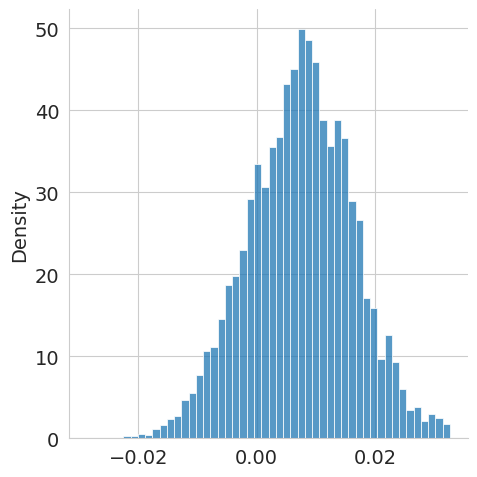

In [127]:

# 3.1

log_prior = lambda mu: stats.norm(0, 1).logpdf(mu)
log_likelihood = lambda mu, x: stats.nct(5, mu).logpdf(x)
log_posterior = lambda mu, x: np.sum(log_prior(mu) + log_likelihood(mu, x))
proposal = lambda theta, sigma, v: v * stats.norm(theta, sigma).rvs()

optimal_v = mcmc_hyperparams_search(
    partial(posterior_mh_mcmc, theta0=0, n=1000, x=data, log_target=log_posterior, proposal=proposal),
    lambda: stats.uniform(0, 1).rvs(),
)

samples, acceptance_rate = posterior_mh_mcmc(0, 10000, data, log_posterior, proposal, v=optimal_v)
print(f"Acceptance rate: {acceptance_rate}")
print(f"Mean: {samples.mean()}")
print(f"Std: {samples.std()}")
sns.displot(samples, stat="density", bins=50)

Iteration 0
New best v: 4.858089029773858
Acceptance rate: 0.001
Iteration 1
New best v: 4.959038409472349
Acceptance rate: 0.002
Iteration 2
New best v: 1.3073003667830196
Acceptance rate: 0.005
Iteration 3
Iteration 4
New best v: 0.8235088882234803
Acceptance rate: 0.009
Iteration 5
Iteration 6
New best v: 0.568427151280374
Acceptance rate: 0.012
Iteration 7
Iteration 8
New best v: 0.25121568834307384
Acceptance rate: 0.024
Iteration 9
New best v: 0.37837315304500463
Acceptance rate: 0.03
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 

/home/sjack/.cache/pypoetry/virtualenvs/computational-statistics-qlF0ErcH-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sjack/.cache/pypoetry/virtualenvs/computational-statistics-qlF0ErcH-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


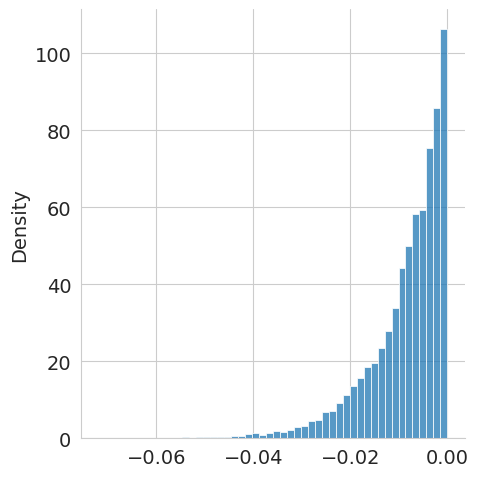

In [128]:

# 3.2

log_prior = lambda mu: stats.uniform(-5, 5).logpdf(mu)

optimal_v = mcmc_hyperparams_search(
    partial(posterior_mh_mcmc, theta0=0, n=1000, x=data, log_target=log_posterior, proposal=proposal),
    lambda: stats.uniform(0, 5).rvs(),
)

optimal_v = mcmc_hyperparams_search(
    partial(posterior_mh_mcmc, theta0=0, n=1000, x=data, log_target=log_posterior, proposal=proposal),
    lambda: stats.uniform(0, 2).rvs(),
)

samples, acceptance_rate = posterior_mh_mcmc(0, 50000, data, log_posterior, proposal, v=optimal_v)
print(f"Acceptance rate: {acceptance_rate}")
print(f"Mean: {samples.mean()}")
print(f"Std: {samples.std()}")
sns.displot(samples, stat="density", bins=50)

## 4. MCMC sampling for the posterior of gamma distribution parameters (6 points)

In this exercise we test Bayesian estimation of the parameters $\alpha, \beta$ of the [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) for a given data set. We will use the shape/rate parametrisation of the gamma distribution. Under this parametrisation, the probability density function of the gamma distribution is
$$ p(x) = \mathrm{Gamma}(x;\; \alpha, \beta) = \frac{\beta^\alpha}{\Gamma(\alpha)} x^{\alpha-1} \exp(-\beta x), \quad \alpha,\beta > 0,$$
where $\Gamma(x)$ is the [gamma function](https://en.wikipedia.org/wiki/Gamma_function).

The prior distributions of the parameters $\alpha$ and $\beta$ are
$$ p(\alpha) = \mathrm{Gamma}\left(\frac{1}{2}, \frac{1}{2}\right), \quad p(\beta) = \mathrm{Gamma}\left(\frac{1}{2}, \frac{1}{2}\right), $$
and we assume a factorized prior, i.e. $$p(\alpha, \beta) = p(\alpha) p(\beta).$$

Please remember that the Gamma distribution has the additional constraint that its parameters $\alpha$ and $\beta$ need to be positive. This can be accomplised by parametrising using new unconstrained variables $a,b$ with $\alpha = \exp(a)$ and $\beta = \exp(b)$.

1. Load the data set $\mathcal{D} = \{ x_i | i = 1, \dots, n \}$ using the function below.
2. Implement the log-probability density function of the gamma distribution. Report the value of the log-probability density $\ln p(\alpha)$ at $\alpha = 1$.
3. Transform the prior probability densities of $\alpha$ and $\beta$ to distributions over unbounded variables $a, b$. Report the log-density value $\ln p(a)$ evaluated at $a=1$ in Moodle. (*Hint*: See Sec. 7.3.3. in the course notes!)
4. Sample from the posterior $$p(a, b | \mathcal{D}) \propto p(\mathcal{D}| a, b) p(a) p(b) = \left[\prod_{i=1}^n \text{Gamma}(x_i; \exp(a), \exp(b))\right] p(a) p(b)$$ using a Metropolis-Hastings sampler. *Note*: The symbol $\propto$ means "proportional to", since we omitted the normalization constant $p(\mathcal{D})$ in the denominator of Bayes' theorem. We can do this since Metropolis-Hastings (as most MCMC samplers) does not need the target density to be normalized.
5. Transform the values of $a,b$ back to $\alpha, \beta$ and report the posterior means and standard deviations (`np.mean(alpha_samples)`, `np.std(alpha_samples)`, `np.mean(beta_samples)`, `np.std(beta_samples)`) for $\alpha$ and $\beta$ in Moodle.

The required tolerance for the posterior statistics is $\pm 0.1$.

*Hints*: 
- You can check your implementations of the probability density functions by making sure they are properly normalised using e.g. `scipy.integrate.quad()`. 
- A multivariate normal distribution centred at the current point should be a good proposal. Remember to throw out the warm-up samples!
- As a help, we already provide an implementation of the log pdf of the gamma distribution.

In [ ]:
import numpy as np
import pandas as pd
import scipy.special as scs

# 1 load dataset

data1 = pd.read_csv('https://raw.githubusercontent.com/lacerbi/compstats-files/main/data/toydata.txt', sep='\t', header=None)
data1 = data1.values
data1 = np.array(data1[:,0])

# 2

def gamma_logpdf(x, alpha, beta):
    """Log pdf of the gamma distribution with shape/rate parameters alpha and beta."""
    return (alpha*np.log(beta) - scs.gammaln(alpha) + (alpha-1) * np.log(x) - beta * x)